# Tarea 1: Piping
### Pablo Correa e Ian Gross

## Librerías

In [105]:
import CoolProp.CoolProp as cp
import fluids as fld
import numpy as np
import scipy.constants as cte
import matplotlib.pyplot as plt

from fluids.units import *

In [106]:
g = cte.g*u.m/u.s**2

## Problema 1
En un sistema de refrigeración, el refrigerante R134a fluye a través de un tubo de cobre estándar tipo
L de 3/4 de pulgada. En este sistema, se utiliza un desuperheter para calentar agua, como se muestra en
la Figura P4.3. El R134a ingresa al desuperheter a 200 psia y 225 ºF. El desuperheter extrae suficiente
energía, $Q_{DSH}$, de manera que el R134a ingresa al condensador como un vapor saturado a una presión
levemente inferior. En el condensador, se transfiere energía desde el refrigerante a una tasa de 60000
Btu/h. Esto hace que el R134a salga del condensador como un líquido saturado con una caída de presión
despreciable.

a. Determine la pérdida de carga en el desuperheater.

In [107]:
# Datos
D = (0.75*u.inch).to(u.m)
P1 = (200*u.psi).to(u.Pa) # psia = psi
T1 = (225*u.fahrenheit).to(u.K)
Q_c = (6E4*u.Btu*u.hr**(-1)).to(u.W)
L = 5*u.m # Longitud del tubo asumida

fluid = 'R134a'
epsilon = fld.material_roughness('Copper')*u.mm

La pérdida de carga en el desuperheater está dado por:
$$\frac{P_1}{\rho_1} = \frac{P_2}{\rho_2} - f\frac{L}{D}\frac{V^2}{2}$$

A la vez, se conocen los estados termodinámicos de entalpía en el condensador, que permiten calcular el flujo másico como sigue:
$$\dot{Q}_c = \Delta h\dot{m}$$

Donde el caudal está dado por:
$$\dot{\forall} = \frac{\dot{m}}{\rho}$$

Y la velocidad:
$$V = \frac{\dot{\forall}}{A} = \frac{\dot{\forall}}{\pi \frac{D^2}{4}}$$

Dado que no se conoce el estado de presión $P_2$, se realiza un experimento numérico, donde se determina que $\rho_2$ presenta muy leves variaciones en el rango de presiones esperado, por lo tanto, se calcula su valor . El mismo escenario es válido para la propiedad $\mu$.

In [108]:
# Propiedades
rho1 = cp.PropsSI('D','T', T1.magnitude, 'P', P1.magnitude, fluid)*u.kg/u.m**3
mu1 = cp.PropsSI('V','T', T1.magnitude, 'P', P1.magnitude, fluid)*u.Pa*u.s
h1 = cp.PropsSI('H','T', T1.magnitude, 'P', P1.magnitude, fluid)*u.J/u.kg # Entrada con datos de presión y temperatura

rho2 = cp.PropsSI('D','Q', 1, 'P', P1.magnitude, fluid)*u.kg/u.m**3
mu2 = cp.PropsSI('V','Q', 1, 'P', P1.magnitude, fluid)*u.Pa*u.s
h2 = cp.PropsSI('H', 'Q', 1, 'P', P1.magnitude, fluid)*u.J/u.kg # Salida del desuperheater (vapor saturado)

rho3 = cp.PropsSI('D','Q', 0, 'P', P1.magnitude, fluid)*u.kg/u.m**3
mu3 = cp.PropsSI('V','Q', 0, 'P', P1.magnitude, fluid)*u.Pa*u.s
h3 = cp.PropsSI('H','Q', 0, 'P', P1.magnitude, fluid)*u.J/u.kg # Salida del condensador (líquido saturado)

print('rho1 =',rho1)
print('rho2 =', rho2)


rho1 = 50.724300150679966 kilogram / meter ** 3
rho2 = 69.68293172549936 kilogram / meter ** 3


In [109]:
# Caudal
dm = Q_c/(h2-h3)
dVol = dm/rho2
V = dVol/(np.pi*D**2/4)
print(f"dm = {dm.to(u.kg/u.s)}")
print(f"dV = {dVol.to(u.L/u.s)}")
print(f"V = {V.to(u.m/u.s)}")

dm = 0.11751193592570336 kilogram / second
dV = 1.6863804810712595 liter / second
V = 5.916647903967142 meter / second


Con la velocidad, se calcula el número de Reynolds y, con este, el factor de fricción.

In [110]:
# Factor de fricción
Re = (fld.Reynolds(D=D, rho=rho1, V=V, mu=mu1)).to('dimensionless')
f = fld.friction.friction_factor(Re=Re, eD=epsilon/D)
print(f"Re = {Re}")
print(f"f = {f}")

Re = 373445.0962286964 dimensionless
f = 0.015506123397328559 dimensionless


Dado que no se conoce el largo de la cañería, se calcula la pérdida de presión por unidad de largo:
$$\frac{\Delta P}{L} = f\frac{V^2}{2Dg}$$

In [111]:
# Pérdida de carga y largo de la tubería
DP_lineal = f*rho1*V**2/(2*D)
print(DP_lineal.to(u.kPa/u.m))

0.7226795653988555 kilopascal / meter


b. Determine la velocidad (m/s) del R134a al ingresar al condensador.
Dado que el sistema presenta una sola vía para el flujo, entonces todos los flujos másicos deben ser equivalentes.

In [112]:
dVol2 = dm/rho2
V2 = dVol2/(np.pi*D**2/4)
print((V2).to(u.m/u.s))


5.916647903967142 meter / second


c. Determine la velocidad (m/s) del R134a al salir del condensador.

Se calcula igual que el punto anterior.

In [113]:
dVol3 = dm/rho3
V3 = dVol3/(np.pi*D**2/4)
print((V3).to(u.m/u.s))

0.37694411151712093 meter / second


d. Investigue sobre correlaciones de pérdida de carga en tuberías con flujo bifásico. Proponga
una expresión para estimar la pérdida de carga en el condensador. ¿qué información sería necesaria?

Una de estas correlaciones es la de Lockhart-Martinelli, la cual compara la caída de presión bifásica con la caída de presión esperada para un sistema con solo líquido o solo gas. Para esto, define un parámetro de calidad del gas como sigue:
$$X^2 = \frac{\bigg(\frac{dp}{dz}\bigg)_L}{\bigg(\frac{dp}{dz}\bigg)_V} = \frac{\phi_V^2}{\phi_L^2}$$
donde $\phi$ son multiplicadores de fricción de dos fases.

Cuando ambas fases son turbulentas la ecuación resultante es:
$$X_{tt} = \bigg(\frac{1-x}{x}\bigg)^{0.9}\bigg(\frac{\rho_V}{\rho_L}\bigg)^{0.5}\bigg(\frac{\mu_L}{\mu_V}\bigg)^{0.1}$$
donde $L$ es el parámetro asociado al líquido y $V$ el parámetro asociado al vapor. [1]

Estos multiplicadores luego se añaden al factor de pérdida por fricción común, por lo tanto, se deben conocer todos los parámetros que se requerían anteriormente. Además, se requiere conocer la calidad de vapor, que se utiliza direcramente en la ecuación, y el régimen de flujo, que tiene que ver con la forma en la que se distribuyen ambas fases dentro de la tubería.

e. Cuál es la diferencia entre una tubería tipo L y una tipo M

Las tuberías tipo L tienen un espesor proporcional mayor al de la tuberías tipo M. Esto les permite soportar mayores presiones y, por lo tanto, se utilizan en aplicaciones industriales o de transporte de gas licuado o gas natural. A motivo del mayor requerimiento de material, las tuberías L tienen un costo más elevado. Además, el mayor espesor de la tubería L le da una durabilidad notablemente mayor frente al mismo uso. [2,3]

## Problema 2
Gas Natural fluye con una velocidad promedio de 100 ft/s por una tubería de cobre de 300 m y $1\frac{1}{4}"$ de diámetro. La temperatura del gas es 20 ◦C y la presión inicial es de 1000 psig.

a. Asumiendo que el flujo es incompresible, determine la variación de la presión (pérdida de
carga) en la tubería.

Bernoulli:
$$\frac{P_1}{\gamma} + \cancel{\frac{V_1^2}{2g}} + \cancel{z_1} = \frac{P_2}{\gamma} + \cancel{\frac{V_2^2}{2g}} + \cancel{z_2} + f\frac{L}{D}\frac{V_2^2}{2g}$$
$$\frac{P_1}{\gamma} = \frac{P_2}{\gamma} + f\frac{L}{D}\frac{V^2}{2g}$$
$$P_2 = P_1 - f\frac{L}{D}\frac{\rho V^2}{2}$$

In [114]:
# Datos
V = (100*u.ft*u.s**(-1)).to(u.m*u.s**(-1))
L = 300 * u.m
D = (1.25 * u.inch).to(u.m)
T = (20 * u.celsius).to(u.K)
P1 = ((1000+14.7)*u.psi).to(u.Pa) # Está en psiG

Para calcular las propiedades del gas natural, es necesario crear una mezcla. Utilizando los datos de Enel [4], se normalizan los tres componentes más relevantes para obtener:

0.931677% Metano, 0.0660455% Etano, 0.00227743% Propano

In [115]:
# Propiedades
fluid = "Methane[0.931677]&Ethane[0.0660455]&Propane[0.00227743]"
rho = cp.PropsSI('D','T', T.magnitude, 'P',P1.magnitude, fluid)*u.kg/u.m**3
mu = cp.PropsSI('V','T', T.magnitude, 'P',P1.magnitude, fluid)*u.Pa*u.s
print(f"rho: {rho1}")
print(f"mu: {mu}")

rho: 50.724300150679966 kilogram / meter ** 3
mu: 1.265970887616968e-05 pascal * second


In [116]:
# Fricción
Re = (fld.Reynolds(D=D, rho=rho, V=V, mu=mu)).to('dimensionless')
epsilon = (fld.material_roughness('Copper'))*u.mm
f = fld.friction.friction_factor(Re, eD=epsilon/D)
print(f"Re = {Re}")
print(f"f = {f}")


Re = 4357915.076040234 dimensionless
f = 0.012278121652104726 dimensionless


In [117]:
# Bernoulli
P2 = P1 - (f*rho*V**2*L)/(2*D)
print(f"P1: {P1}")
print(f"P2: {P2}")


P1: 6996110.225377939 pascal
P2: 3923884.1136408392 pascal


b. Determine el grado de error introducido por el supuesto.

Partiendo de la ecuación inicial:
$$\frac{P_1}{\gamma_1} = \frac{P_2}{\gamma_2} + f\frac{L}{D}\frac{V^2}{2g}$$
Se divide en pequeños tramos para realizar una iteración:
$$\frac{P_i}{\rho} = \frac{P_{i+1}}{\rho} + f\frac{dL}{D}\frac{V^2}{2}$$
$$P_{i+1} = P_i - f\frac{dL}{D}\frac{\rho V^2}{2}$$

In [118]:
# Condiciones iniciales
Pi = ((1000+14.7)*u.psi).to(u.Pa)
rhoi = cp.PropsSI('D','T', T.magnitude, 'P',Pi.magnitude, fluid)*u.kg/u.m**3
mui = cp.PropsSI('V','T', T.magnitude, 'P',Pi.magnitude, fluid)*u.Pa*u.s
Rei = (fld.Reynolds(D=D, rho=rhoi, V=V, mu=mui))
fi = fld.friction.friction_factor(Rei, eD=epsilon/D)

# Tramos
n = 50
# Largo del tramo
dL = L/n

for i in range(n):
    Pi -= (f*rhoi*V**2*dL)/(2*D)
    # Se actualiza la densidad con la nueva presión
    rhoi = cp.PropsSI('D','T', T.magnitude, 'P',Pi.magnitude, fluid)*u.kg/u.m**3
    mui = cp.PropsSI('V','T', T.magnitude, 'P',Pi.magnitude, fluid)*u.Pa*u.s
    Rei = (fld.Reynolds(D=D, rho=rhoi, V=V, mu=mui))
    fi = fld.friction.friction_factor(Rei, eD=epsilon/D)
print(f"rhoi: {rhoi}")
print(f"Pi: {Pi}")


rhoi: 35.19673866374126 kilogram / meter ** 3
Pi: 4556265.803968898 pascal


Considerando la desviación del cálculo incompresible con respecto al compresible:
$$error = \frac{P_i-P_2}{P_i}$$

In [119]:
err = (Pi-P2)/Pi
print(f"Error: {err}")

Error: 0.13879385390053411 dimensionless


Se obtiene un 13\% de error con respecto al valor compresible. De este modo, el valor incompresible permite hacerse una idea general de la pérdida de carga del sistema para un cálculo rápido, pero no entrega valores confiables para el diseño de sistemas complejos.

c. Verifique la validez del supuesto.

In [120]:
rho1 = cp.PropsSI('D','T', T.magnitude, 'P', P1.magnitude, fluid) * u.kg/(u.m)**3
rho2 = cp.PropsSI('D', 'T',T.magnitude, 'P', P2.magnitude, fluid) * u.kg/(u.m)**3
print(f"rho1: {rho1}")
print(f"rho2: {rho2}")
print(f"r_rho: {rho2/rho1}")

rho1: 57.00904806016102 kilogram / meter ** 3
rho2: 29.88707315407117 kilogram / meter ** 3
r_rho: 0.5242513981733509 dimensionless


Este supuesto no es muy válido, pues la densidad del Gas Natural disminuye a alrededor de un 52\% de su valor inicial para la baja de presión evidenciada, este efecto será más notorio a medida que la tubería se alarge, pues también será mayor la pérdida de carga.

d. Haga una evaluación (gráfico) del error vs longitud de la tubería.

In [121]:
# Puntos para graficar 
l_L = [10, 50, 100, 200, 300, 400, 500]*u.m
l_Pi = []
l_P2 = []

# Tramos
n = 30

for j in range(len(l_L)):
    # Condiciones iniciales
    Pi = ((1000+14.7)*u.psi).to(u.Pa)
    rhoi = cp.PropsSI('D','T', T.magnitude, 'P',Pi.magnitude, fluid)*u.kg/u.m**3
    mui = cp.PropsSI('V','T', T.magnitude, 'P',Pi.magnitude, fluid)*u.Pa*u.s
    Rei = (fld.Reynolds(D=D, rho=rhoi, V=V, mu=mui))
    fi = fld.friction.friction_factor(Rei, eD=epsilon/D)
    
    P2 = Pi - (fi*rhoi*V**2*l_L[j])/(2*D)

    for i in range(n):
        dL = l_L[j]/n
        Pi -= (fi*rhoi*V**2*dL)/(2*D)
        # Se actualiza la densidad con la nueva presión
        rhoi = cp.PropsSI('D','T', T.magnitude, 'P',Pi.magnitude, fluid)*u.kg/u.m**3
        mui = cp.PropsSI('V','T', T.magnitude, 'P',Pi.magnitude, fluid)*u.Pa*u.s
        Rei = (fld.Reynolds(D=D, rho=rhoi, V=V, mu=mui))
        fi = fld.friction.friction_factor(Rei, eD=epsilon/D)

    l_P2.append(P2.magnitude)
    l_Pi.append(Pi.magnitude)
l_P2 *= u.Pa
l_Pi *= u.Pa


c:\Users\iangr\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\cbook.py:1398: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(x, float)


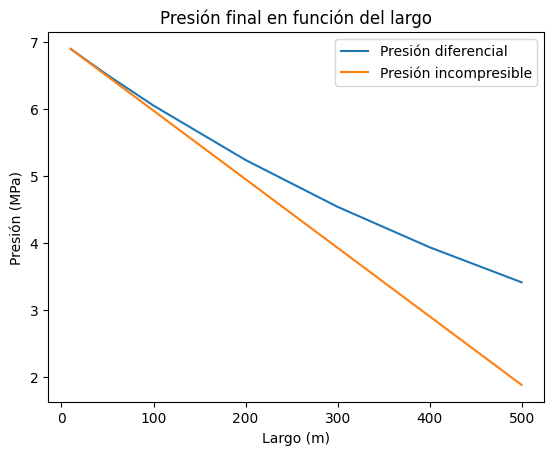

In [122]:
plt.plot(l_L, (l_Pi).to(u.MPa), label='Presión diferencial')
plt.plot(l_L, (l_P2).to(u.MPa), label='Presión incompresible')
plt.title('Presión final en función del largo')
plt.xlabel('Largo (m)')
plt.ylabel('Presión (MPa)')
plt.legend()
plt.show()

In [123]:
l_err = []
for i in range(len(l_Pi)):
    l_err.append(100*(l_Pi[i].magnitude-l_P2[i].magnitude)/l_Pi[i].magnitude)
print(l_err)

[0.011682527527035441, 0.30205967385447385, 1.2605407190424263, 5.4947170830695615, 13.497404656336407, 26.25056577911884, 44.97130558916112]


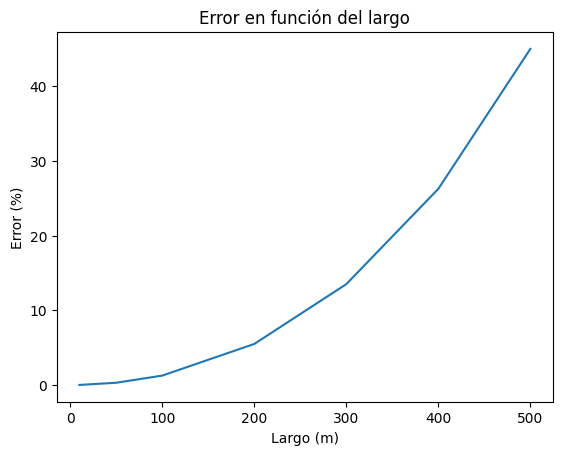

In [124]:
plt.plot(l_L, l_err)
plt.title('Error en función del largo')
plt.xlabel('Largo (m)')
plt.ylabel('Error (%)')
plt.show()

e. ¿Cuánto influencia la temperatura en la pérdida de carga? Grafique.

Realizando el mismo procedicimiento que antes, pero esta vez variando la temperatura, se obtiene:

In [125]:
# Puntos para graficar 
l_T = ([-10, 0, 10, 20, 30, 40, 50]*u.celsius).to(u.K)
l_Pi = []
l_P2 = []

# Tramos
n = 30
dL = L/n

for j in range(len(l_T)):
    # Condiciones iniciales
    Pi = ((1000+14.7)*u.psi).to(u.Pa)
    rhoi = cp.PropsSI('D','T', l_T[j].magnitude, 'P',Pi.magnitude, fluid)*u.kg/u.m**3
    mui = cp.PropsSI('V','T', l_T[j].magnitude, 'P',Pi.magnitude, fluid)*u.Pa*u.s
    Rei = (fld.Reynolds(D=D, rho=rhoi, V=V, mu=mui))
    fi = fld.friction.friction_factor(Rei, eD=epsilon/D)
    
    P2 = Pi - (fi*rhoi*V**2*L)/(2*D)

    for i in range(n):
        Pi -= (fi*rhoi*V**2*dL)/(2*D)
        # Se actualiza la densidad con la nueva presión
        rhoi = cp.PropsSI('D','T', l_T[j].magnitude, 'P',Pi.magnitude, fluid)*u.kg/u.m**3
        mui = cp.PropsSI('V','T', l_T[j].magnitude, 'P',Pi.magnitude, fluid)*u.Pa*u.s
        Rei = (fld.Reynolds(D=D, rho=rhoi, V=V, mu=mui))
        fi = fld.friction.friction_factor(Rei, eD=epsilon/D)

    l_P2.append(P2.magnitude)
    l_Pi.append(Pi.magnitude)
l_P2 *= u.Pa
l_Pi *= u.Pa

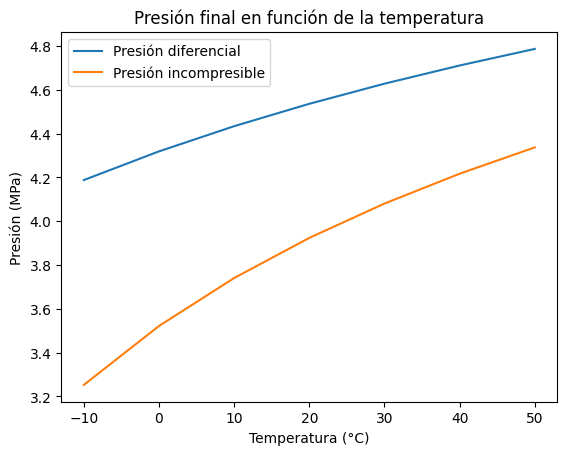

In [126]:
plt.plot((l_T).to(u.celsius), (l_Pi).to(u.MPa), label='Presión diferencial')
plt.plot((l_T).to(u.celsius), (l_P2).to(u.MPa), label='Presión incompresible')
plt.title('Presión final en función de la temperatura')
plt.xlabel('Temperatura (°C)')
plt.ylabel('Presión (MPa)')
plt.legend()
plt.show()

## Problema 3
Se utiliza una tubería horizontal para transportar etanol (alcohol etílico) a 20 ◦C a lo largo de una
distancia de 3 km. La tubería está hecha de acero comercial. El caudal requerido de etanol es de 40
L/s. La bomba conectada a esta tubería puede superar una caída de presión de hasta 200 kPa en la
tubería.

a. Especifique el tamaño apropiado (diámetro nominal) de una tubería de tipo Schedule 40 para esta tubería.
Se toma el valor de epsilon de PipeFlow [5]

In [196]:
# Datos
T = (20 * u.celsius).to(u.K)
L = 3E3 * u.m
dVol = 40 * u.L*u.s**(-1)
DP_max = 200E3 * u.Pa

fluid = "Ethanol"
epsilon = (0.045*u.mm).to(u.m)

In [197]:
# Propiedades
rho = cp.PropsSI('D','Q', 0, 'P', DP_max.magnitude, fluid)*u.kg/u.m**3
mu = cp.PropsSI('V','Q', 0, 'P', DP_max.magnitude, fluid)*u.Pa*u.s

Bernoulli:
$$\frac{P_1}{\gamma} + \cancel{\frac{V_1^2}{2g}} + \cancel{z_1} = \frac{P_2}{\gamma} + \cancel{\frac{V_2^2}{2g}} + \cancel{z_2} + f\frac{L}{D}\frac{V_2^2}{2g}$$
Se obtiene un sistema de dos ecuaciones.
$$200kPa \geq \Delta P = f\frac{L}{D}\frac{\rho V^2}{2} = f\frac{8\rho L}{D^5\pi^2}\dot{\forall}^2$$
$$40Ls^{-1} = \dot{\forall} = VA = V\frac{\pi D^2}{4}$$
Se quiere resolver para D, por lo tanto:
$$200kPa \geq \Delta P = f\frac{8\rho L}{D^5\pi^2}\dot{\forall}^2$$
$$V = \frac{160Ls^{-1}}{\pi D^2}$$
Como existe diámetros fijos para las tuberías schedule 40, se crea una lista con valores extraídos de Wesco [6]. Además, por propósitos de simplicidad, se redondean los valores obtenidos, tratando de mantener por lo menos tres figuras significativas.

In [198]:
l_D = ([1/8, 1/4, 3/8, 1/2, 3/4, 1, 1.25, 1.5, 2, 2.5, 3, 3.5, 4, 6, 8, 10]*u.inch).to(u.m)

V = (4*dVol/(np.pi*l_D**2)).to(u.m/u.s)

l_Re = []
l_f = []
for i in range(len(l_D)):
    Re = (fld.Reynolds(D=l_D[i], rho=rho, V=V[i], mu=mu)).to('dimensionless')
    l_Re.append(int(Re.magnitude))
    f = fld.friction.friction_factor(Re=l_Re[i], eD=epsilon/l_D[i])
    l_f.append(f.magnitude.round(4))
print(f"Re = {l_Re}")
print(f"f = {l_f}")

Re = [33909193, 16954596, 11303064, 8477298, 5651532, 4238649, 3390919, 2825766, 2119324, 1695459, 1412883, 1211042, 1059662, 706441, 529831, 423864]
f = [0.0428, 0.0339, 0.0299, 0.0274, 0.0245, 0.0227, 0.0215, 0.0206, 0.0192, 0.0183, 0.0177, 0.0172, 0.0168, 0.0159, 0.0156, 0.0155]


In [199]:
l_DP = []
l_DP2 = []
for i in range(len(l_D)):
    DP = l_f[i]*rho*V[i]**2*L/(2*l_D[i])
    l_DP.append(int(DP.magnitude))
l_DP *= u.Pa
print(f"DP = {l_DP}")

DP = [370366958406874   9167231228090   1064764052956    231546953954     27264547760      5994657681      1860488225       716389902       158449101        49486823        19235590         8648220         4332592          539982          125722           40932] pascal


In [200]:
for i in range(len(l_DP)):
    if l_DP[i].magnitude < DP_max.magnitude:
        print(f"La menor cañería que cumple las especificaciones del problema es:")
        print(f"D = {l_D[i].to(u.inch)}")
        print(f"Con una caida de presión de {l_DP[i]}")
        break

La menor cañería que cumple las especificaciones del problema es:
D = 8.0 inch
Con una caida de presión de 125722 pascal


b. Grafique el caudal máximo que sería entregado por diferentes diametros del schedule
indicado.

Esta vez, se asume que la presión queda fija en $200kPa$ y así obtener el valor máximo:
$$200kPa = f\frac{L}{D}\frac{\rho V^2}{2}$$
$$40Ls^{-1} = \dot{\forall} = VA = V\frac{\pi D^2}{4}$$
Reordenando:
$$V = \sqrt{\frac{2D\times 200kPa}{fL\rho}}$$
$$\dot{\forall} = V\frac{\pi D^2}{4}$$


In [202]:
l_dVol = []
for i in range(len(l_D)):
    V = np.sqrt(2*l_D[i]*DP_max/(l_f[i]*rho*L))
    dVol = (V*np.pi*l_D[i]**2/4).to(u.L/u.s)
    l_dVol.append(dVol.magnitude)
print(f"dVol = {l_dVol}")

dVol = [0.0009295202846101689, 0.005908209630868708, 0.017335976069656388, 0.0371753831324785, 0.10833675921357823, 0.23104298936000328, 0.4147262513585722, 0.6683443194043839, 1.4211178631425039, 2.5429053790596297, 4.078704361282939, 6.082913084188681, 8.59411302762649, 24.343627136922926, 50.45083888283681, 88.417834595838]


c:\Users\iangr\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\cbook.py:1398: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(x, float)


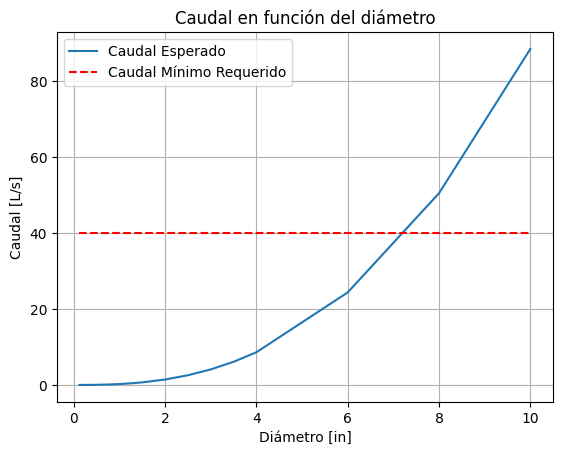

In [203]:
plt.plot(l_D.to(u.inch), l_dVol, label="Caudal Esperado")
plt.plot(l_D.to(u.inch), 40*np.ones(len(l_D)), 'r--', label = "Caudal Mínimo Requerido")
plt.title("Caudal en función del diámetro")
plt.xlabel("Diámetro [in]")
plt.ylabel("Caudal [L/s]")
plt.grid()
plt.legend()
plt.show()

## Problema 4
Considere el plano hidráulico de la localidad de Hualañé.

a. Establezca un código computacional, que permita estimar la pérdida de carga máxima en el sistema, cuando todas las casas tienen una llave de
lavamanos abierta.

De acuerdo a la Superintendencia de Servicios Sanitarios, "el Manual de Proyectos de Agua Potable Rural 2019, dicta que los servicios que fueron construidos y rehabilitados a partir del año 2020 deberán tener una presión mínima de servicio de 15 metros columna de agua (1,5 bar), y una máxima de 70 metros columna de agua (7bar)". Además, la pérdida de carga en el arranque no debe superar los 5mca al abrir la llave [7].

Con respecto al caudal, este presenta una decisión de diseño, "el caudal recomendado para uso doméstico es entre 10 y 18 litros por minuto" [8]. Considerando una llave abierta por cada casa, y un total de 20 casas conectadas a la red (+2 desconectadas), el caudal debe ser un mínimo de $200Lmin^{-1}$ o $220Lmin^{-1}$ considerando que las otras dos casas se puedan conectar a la red.

Con respecto al diámetro de las tuberías, "las velocidades del agua en las tuberías no deben exceder de 2,5 m/s en las tuberías exteriores y de distribución principal" [9]. Es decir, se deben escoger considerando el siguiente criterio:
$$V = \frac{\dot{\forall}}{\pi \frac{D^2}{4}}$$
$$D_{min} = \sqrt{\frac{4\dot{\forall}}{\pi V}}$$
Con:
$$V = 2.5ms^{-1}$$

Como en este caso, todas las casas se encuentran paralelas en el circuito, la presión sin considerar pérdidas de carga deberá ser para todas las casas igual.

In [224]:
dVol_p = (220*u.L/u.min).to(u.L/u.s) # Caudal de agua en tuberia principal
dVol_s = (40*u.L/u.min).to(u.L/u.s) # Caudal de agua máximo en tuberia secundaria
Dmin_p = np.sqrt(4*dVol_p/(np.pi*2.5*u.m/u.s)) # Diámetro mínimo principal
Dmin_s = np.sqrt(4*dVol_s/(np.pi*2.5*u.m/u.s)) # Diámetro mínimo secundario
print(f"Diámetro mínimo principal requerido = {Dmin_p.to(u.inch)}")
print(f"Diámetro mínimo bifurcación requerido = {Dmin_s.to(u.inch)}")

Diámetro mínimo principal requerido = 1.7013240982752162 inch
Diámetro mínimo bifurcación requerido = 0.7254470330106781 inch


Es decir, se requiere una tubería central de por lo menos $1\frac{3}{4}"$. Por otro lado, la bifurcación más grande del sistema alimenta a cuatro casas, por lo que una tubería de $1"$ sería suficiente para el resto de la red.

Luego, se establece el largo de las tuberías de la red hasta la última casa, se toman las medidas del plano, y se consideran las alturas (en algunos casos de forma aproximada). Dependiendo de la uniformidad de la pendiente, se pueden separar en tramos menores:
$$L = \sum_i\sqrt{x_i^2+y_i^2+z_i^2}$$ 

In [372]:
T = (20*u.celsius).to(u.K) # Temperatura del suelo
P = (1.51*u.MPa).to(u.Pa) # Considerando la mínima presión requerida por norma

D_p = (1.75*u.inch).to(u.m) # Diámetro del tubo central
D_s = (1*u.inch).to(u.m) # Diámetro de los tubos individuales
V_p = dVol_p/(np.pi*D_p**2/4) # Velocidad en el tubo central
V_s = dVol_s/(np.pi*D_s**2/4) # Velocidad en los tubos individuales

epsilon = (0.0015*u.mm).to(u.m) # Rugosidad del tubo [10]

fluid = "water"

print(f"V_p = {V_p.to(u.m/u.s)}")
print(f"V_s = {V_s.to(u.m/u.s)}")


V_p = 2.3628601529567175 meter / second
V_s = 1.3156834942599904 meter / second


Se asume que, para el rango de operación, el agua es incompresible, y mantiene su viscocidad constante.

In [373]:
rho = cp.PropsSI('D','T', T.magnitude, 'P', P.magnitude, fluid)*u.kg/u.m**3
mu = cp.PropsSI('V','T', T.magnitude, 'P', P.magnitude, fluid)*u.Pa*u.s

Re_p = (fld.Reynolds(D=D_p, rho=rho, V=V_p, mu=mu))
f_p = fld.friction.friction_factor(Re_p, eD=epsilon/D_p)

Re_s = (fld.Reynolds(D=D_s, rho=rho, V=V_s, mu=mu))
f_s = fld.friction.friction_factor(Re_s, eD=epsilon/D_s)

print(f"f_p = {f_p}")
print(f"f_s = {f_s}")


f_p = 0.018001309657908367 dimensionless
f_s = 0.023080341676288495 dimensionless


Bernoulli:
$$\frac{P_1}{\gamma} + z_1 = \frac{P_2}{\gamma} + z_2 + f\frac{L}{D}\frac{V_2^2}{2g}$$

In [397]:
# Largo de la tubería principal por tramos
Lp1 = 48.55
Lp2 = np.sqrt(4.79**2 + 1.03**2) + np.sqrt(120**2+ (108.17-101.03)**2) + np.sqrt(20**2 + (144.79-124.79)**2) + 4
Lp3 = 16 + np.sqrt(216**2 + 120.748**2-111.198**2)
Lp4 = np.sqrt(40**2 + (404.79-364.79)**2)
Lp5 = 14.28
LpT = [Lp1, Lp2, Lp3, Lp4, Lp5]*u.m

# Largo de tuberías secundarias por tramos
Ls1 = 193.36
Ls23 = 14.53 + np.sqrt(8**2 + 5**2) +88.35 + 153.65
Ls4 = 12
Ls5 = 1.84
Ls6789 = 17.27 + np.sqrt(62**2 + (300-230)**2) + 23 + 29.37 + 110.27 + 14.08
Ls10 = 41.89
Ls11 = 14.31
Ls1213 = 14.09 + np.sqrt(12**2 + 8**2) + 15 + 2
Ls14 = 5.85
Ls15 = 5.89
Ls16 = 50.73 + np.sqrt(22.32**2 + 20**2)
Ls17181920 = np.sqrt(9**2 + 9**2) + 2 + 2 + 2 + 17
LsT = [Ls1, Ls23, Ls4, Ls5, Ls6789, Ls10, Ls11, Ls1213, Ls14, Ls15, Ls16, Ls17181920]*u.m


Se considera la perdida de presión asociada a cada tramo, tal que:
$$\Delta P = \sum_i \Delta P_i$$

In [377]:
DP = 0
for i in LpT:
    DP_i = f_p*rho*V_p**2*i/(2*D_p)
    DP += DP_i
for i in LsT:
    DP_i = f_s*rho*V_s**2*i/(2*D_s)
    DP += DP_i

print(f"DP = {DP.to(u.Pa)}")
print(f"Pf = {(P-DP).to(u.Pa)} = {(P-DP).magnitude/9806} mca")

DP = 1358409.0887874314 pascal
Pf = 151590.91121256864 pascal = 15.45899563660704 mca


Iterando sobre el valor de la presión inicial, se busca un resultado final de $P_f$ tal que la presión operativa del sistema sea mayor a los 15 metros columna de agua requeridos por la norma de la Superintendencia de Servicios Sanitarios. De este modo, es necesario tener una bomba de por lo menos $1.51MPa$ para suministrar la presión suficiente. Dado que este estudio no considera perdidas por singularidad, ni otros posibles factores, lo recomendable sería buscar una presión más alta de operación. En ese sentido, se espera que una bomba de hasta $2.04MPa$ funcione dentro del marco normativo.

b. Grafique la pérdida de carga asociada a cada casa si el diámetro de todas las
tuberías es de 1 pulgada.

In [398]:
D_p = (1*u.inch).to(u.m) # Diámetro del tubo central
D_s = (1*u.inch).to(u.m) # Diámetro de los tubos individuales

V_p = dVol_p/(np.pi*D_p**2/4) # Velocidad en el tubo central
V_s = dVol_s/(np.pi*D_s**2/4) # Velocidad en los tubos individuales

Re_p = (fld.Reynolds(D=D_p, rho=rho, V=V_p, mu=mu))
f_p = fld.friction.friction_factor(Re_p, eD=epsilon/D_p)

Re_s = (fld.Reynolds(D=D_s, rho=rho, V=V_s, mu=mu))
f_s = fld.friction.friction_factor(Re_s, eD=epsilon/D_s)

In [399]:
# Largo de camino recorrido a cada casa
C1 = Lp1 + Lp2 + 193.36
C2 = Lp1 + Lp2 + 0.13*Lp3 + 14.53 + np.sqrt(3**2 + 2**2) + 88.35
C3 = Lp1 + Lp2 + 0.13*Lp3 + 14.53 + np.sqrt(5**2 + 3**2) + 153.65
C4 = Lp1 + Lp2 + 0.15*Lp3 + 12
C5 = Lp1 + Lp2 + 0.27*Lp3 + 1.84
C6 = Lp1 + Lp2 + 0.48*Lp3 + 17.27 + np.sqrt(25**2 + 28**2) + 23
C7 = Lp1 + Lp2 + 0.48*Lp3 + 17.27 + 1 + 29.37
C8 = Lp1 + Lp2 + 0.48*Lp3 + 17.27 + np.sqrt(30**2 + 35**2) + 110.27
C9 = Lp1 + Lp2 + 0.48*Lp3 + 17.27 + np.sqrt(37**2 + 42**2) + 14.08
C10 = Lp1 + Lp2 + 0.59*Lp3 + 41.89
C11 = Lp1 + Lp2 + 0.9*Lp3 + 14.31
C12 = Lp1 + Lp2 + 0.91*Lp3 + 14.09 + np.sqrt(5**2 + 3**2) + 15
C13 = Lp1 + Lp2 + 0.91*Lp3 + 14.09 + np.sqrt(7**2 + 4**2) + 2
C14 = Lp1 + Lp2 + Lp3 + 5.85
C15 = Lp1 + Lp2 + Lp3 + 0.42*Lp4 + 5.89
C16 = Lp1 + Lp2 + Lp3 + Lp4 + Lp5 + 50.73 + np.sqrt(22.32**2 + 20**2)
C17 = Lp1 + Lp2 + Lp3 + Lp4 + Lp5 + np.sqrt(4.5**2 + 4.5**2) + 2
C18 = Lp1 + Lp2 + Lp3 + Lp4 + Lp5 + np.sqrt(2.3**2 + 2.3**2) + 2
C19 = Lp1 + Lp2 + Lp3 + Lp4 + Lp5 + np.sqrt(2.3**2 + 2.3**2) + 2
C20 = Lp1 + Lp2 + Lp3 + Lp4 + Lp5 + np.sqrt(4.5**2 + 4.5**2) + 17
CT = [C1, C2, C3, C4, C5, C6, C7, C8, C9, C10, C11, C12, C13, C14, C15, C16, C17, C18, C19, C20]*u.m

In [400]:
DP_C = []
for i in CT:
    DP_i = (f_s*rho*V_s**2*i/(2*D_s)).to(u.kPa)
    DP_C.append(DP_i.magnitude)

x = list(range(1, 21))


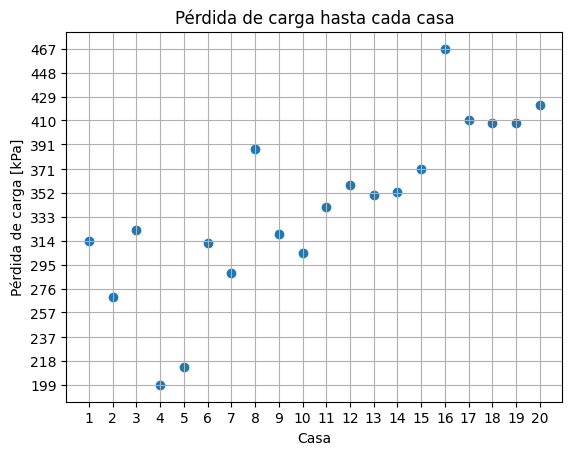

In [404]:
plt.scatter(x, DP_C)
plt.title('Pérdida de carga hasta cada casa')
plt.xlabel('Casa')
plt.ylabel('Pérdida de carga [kPa]')
plt.xticks(np.arange(min(x), max(x)+1, 1))
y_min, y_max = min(DP_C), max(DP_C)
yticks = np.linspace(y_min, y_max, num=15).round(0)
plt.yticks(yticks)
plt.grid()
plt.show()

Cabe recalcar que, de esta forma, existen muchos tramos cuyas pérdidas se cuentan varias veces.

# Bibliografía

[1] https://www.sciencedirect.com/topics/engineering/martinelli-parameter

[2] https://woolfplumbing.com.au/blog/the-differences-between-copper-pipes-type-l-and-type-m

[3] https://sodimac.falabella.com/sodimac-cl/page/como-elegir-tuberias-y-fittings-de-cobre

[4] https://www.enel.cl/es/inversionistas/inversionistas-enel-generacion/nuestras-centrales/gasoducto/informacion-general.html

[5] https://www.pipeflow.com/pipe-pressure-drop-calculations/pipe-roughness

[6] https://www.wesco.com.co/default.asp?iID=GFLJKE

[7] https://www.siss.gob.cl/586/articles-19503_Man_Pre_SSR.pdf

[8] https://www.junkers-bosch.es/conocimiento/agua-caliente/caudal-minimo/

[9]] https://www.google.com/url?sa=t&source=web&rct=j&opi=89978449&url=https://estudiantes.cftla.cl/parciales/descargar.php%3Fidm%3D66311&ved=2ahUKEwjWtYXRu7GIAxWcCrkGHTjxGw0QFnoECBYQAQ&usg=AOvVaw2tcraPkc8wn1s3hNnku404

[10] http://catarina.udlap.mx/u_dl_a/tales/documentos/mgc/osorio_e_fj/capitulo3.pdf